# EGO Facebook

In [21]:
import math, subprocess
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import os
import networkx as nx

In [7]:
def metodo_de_la_potencia(matriz):
    return np.linalg.eig(matriz)

# Item 3.1
## Con los datos de Facebook, computar la matriz de similaridad con producto interno de la matriz de atributos

In [8]:
def calcular_matriz_similaridad(matriz: np.matrix) -> np.matrix:
    return np.dot(matriz, np.transpose(matriz))

In [9]:
# Levantamos la matriz de atributos
f = open("../tests/ego-facebook.feat", "r")
lineas = []
for linea in f:
    lineas.append([int(i) for i in linea.split(" ")])
nodes = [linea[0] for linea in lineas]
attributes = np.matrix([linea[1:] for linea in lineas])
matriz_similaridad = calcular_matriz_similaridad(attributes)
matriz_similaridad = matriz_similaridad / np.max(matriz_similaridad)

In [10]:
# Levantamos la matriz con los resultados de la realidad
f = open("../tests/ego-facebook.edges", "r")
resultados_esperados = np.zeros((len(nodes), len(nodes)))
for linea in f:
    desde, hasta = [int(i) for i in linea.split(" ")]
    resultados_esperados[nodes.index(desde), nodes.index(hasta)] = 1

In [11]:
# Calculamos el puntaje de la matriz contando la cantidad de correctos dividido el total de elementos
def calcular_puntaje(matriz: np.matrix, esperado: np.matrix) -> float:
    return np.sum(matriz == esperado) / (matriz.shape[0] * matriz.shape[1])

In [12]:
def falsos_positivos(matriz: np.matrix, esperado: np.matrix) -> float:
    return np.sum(np.logical_and(matriz == 1, esperado == 0)) / (matriz.shape[0] * matriz.shape[1])

In [13]:
def falsos_negativos(matriz: np.matrix, esperado: np.matrix) -> float:
    return np.sum(np.logical_and(matriz == 0, esperado == 1)) / (matriz.shape[0] * matriz.shape[1])

In [14]:
def verdaderos_positivos(matriz: np.matrix, esperado: np.matrix) -> float:
    return np.sum(np.logical_and(matriz == 1, esperado == 1)) / (matriz.shape[0] * matriz.shape[1])

In [15]:
def verdaderos_negativos(matriz: np.matrix, esperado: np.matrix) -> float:
    return np.sum(np.logical_and(matriz == 0, esperado == 0)) / (matriz.shape[0] * matriz.shape[1])

count    9.000000
mean     0.900060
std      0.123747
min      0.585124
25%      0.943239
50%      0.954990
75%      0.955201
max      0.955268
dtype: float64


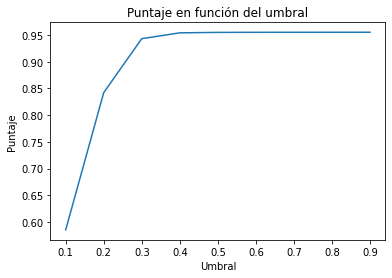

In [16]:
# Comparamos la matriz de similaridad con distintos umbrales contra los resultados reales
umbrales = np.arange(0.1, 1, 0.1)
puntajes = []
for umbral in umbrales:
    red = (matriz_similaridad > umbral).astype(int)
    puntajes.append(calcular_puntaje(red, resultados_esperados))
print(pd.Series(puntajes).describe())

plt.plot(umbrales, puntajes)
plt.xlabel("Umbral")
plt.ylabel("Puntaje")
plt.title("Puntaje en función del umbral")

plt.savefig('./graficos/puntaje-umbral.png')
plt.show()
plt.close()

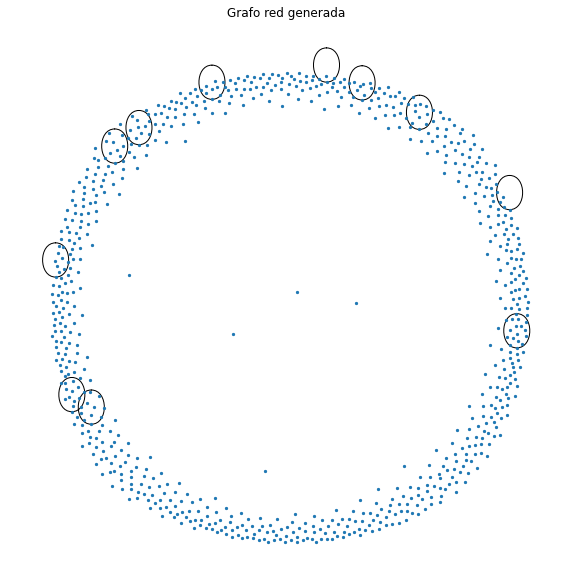

In [24]:
# TODO graficar la red con el umbral 0.5
red_generada = (matriz_similaridad > umbral).astype(int)
G = nx.Graph()
G.add_nodes_from(nodes)
for i in range(len(nodes)):
    for j in range(len(nodes)):
        if (red_generada[i, j] == 1):
            G.add_edge(nodes[i], nodes[j])
plt.figure(2,figsize=(10,10))
ax = plt.gca()
ax.set_title('Grafo red generada')
nx.draw_networkx(G, pos=nx.spring_layout(G, seed=10), node_size=5, ax=ax, with_labels=False)
_ = ax.axis('off')
plt.savefig('./graficos/grafo-estimado.png')
plt.show()
plt.close()

## Aplicamos PCA

In [18]:
def calcular_matriz_covarianza(matriz: np.matrix) -> np.matrix:
    return np.dot(matriz.transpose(), matriz)

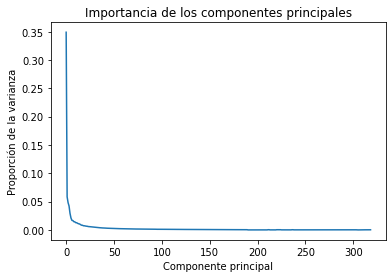

In [19]:
# Convertimos la media y varianza en cero
atributos_pca: np.matrix = attributes
atributos_pca = np.subtract(atributos_pca, atributos_pca.mean())
atributos_pca = np.divide(atributos_pca, atributos_pca.std())
matriz_covarianza = calcular_matriz_covarianza(atributos_pca)
autovalores, autovectores = metodo_de_la_potencia(matriz_covarianza)
# Factorizamos C = VDVt
D: np.matrix = np.diag(autovalores)
V: np.matrix = autovectores
# Analizamos los componentes principales
plt.plot([i for i in range(len(autovalores))], [i / sum(autovalores) for i in autovalores])
plt.xlabel("Componente principal")
plt.ylabel("Proporción de la varianza")
plt.title("Importancia de los componentes principales")
plt.savefig('./graficos/importancia-cp.png')
plt.show()
plt.close()

1 componentes principales
count    9.000000
mean     0.628752
std      0.292762
min      0.130943
25%      0.490773
50%      0.657250
75%      0.875539
max      0.954443
dtype: float64
3 componentes principales
count    9.000000
mean     0.712009
std      0.292448
min      0.132848
25%      0.579950
50%      0.822687
75%      0.948511
max      0.955228
dtype: float64
6 componentes principales
count    9.000000
mean     0.743675
std      0.279418
min      0.185589
25%      0.645098
50%      0.886203
75%      0.951161
max      0.955277
dtype: float64
25 componentes principales
count    9.000000
mean     0.854793
std      0.207133
min      0.343093
25%      0.911516
50%      0.954640
75%      0.955231
max      0.955284
dtype: float64
50 componentes principales
count    9.000000
mean     0.889666
std      0.151754
min      0.498315
25%      0.941624
50%      0.954989
75%      0.955226
max      0.955277
dtype: float64
100 componentes principales
count    9.000000
mean     0.896619
std      

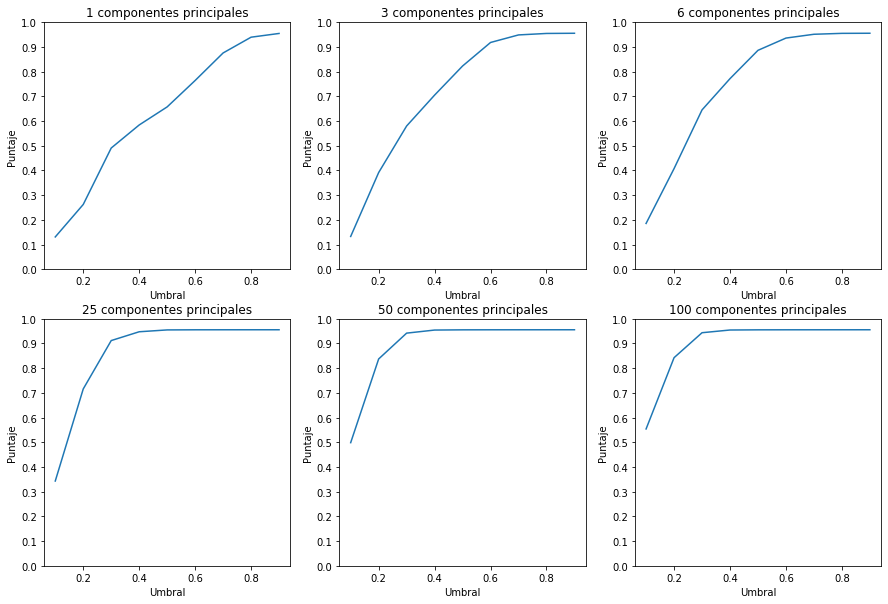

In [20]:
k_a_evaluar = [1, 3, 6, 25, 50, 100]
umbrales = np.arange(0.1, 1, 0.1)
fig, subplots = plt.subplots(2, 3, figsize = (15,10))
i = 0
for k in k_a_evaluar:
    # Generamos la nueva matriz de atributos
    nueva_matriz_atributos = np.dot(atributos_pca, V[:, :k])
    nueva_matriz_similaridad = calcular_matriz_similaridad(nueva_matriz_atributos)
    nueva_matriz_similaridad = nueva_matriz_similaridad / np.max(nueva_matriz_similaridad)
    # Calculamos los puntajes para cada umbral
    puntajes = []
    for umbral in umbrales:
        red = (nueva_matriz_similaridad > umbral).astype(int)
        puntajes.append(calcular_puntaje(red, resultados_esperados))
    print(f'{k} componentes principales')
    print(pd.Series(puntajes).describe())
    subplots[int(i/3)][i%3].plot(umbrales, puntajes)
    subplots[int(i/3)][i%3].set_yticks(np.arange(0, 1.01, .1))
    subplots[int(i/3)][i%3].set_xlabel("Umbral")
    subplots[int(i/3)][i%3].set_ylabel("Puntaje")
    subplots[int(i/3)][i%3].set_title(f"{k} componentes principales")
    i += 1

plt.savefig('./graficos/componentes-principales-puntaje-umbral.png')
plt.show()
plt.close()